In this tutorial, we will utilize a simulated processed loggerhead sea turtle (Caretta caretta) track to explore how this pelagic forager interacts with mesoscale oceanographic features. 

We will also use the Sea Surface Height (SSH) - derived mesoscale eddy product maintained by AVISO. Access to AVISO data products is free, but requires an account. If you do not already have an account, create one here: https://www.aviso.altimetry.fr/en/data/data-access/registration-form.html

In [1]:
%matplotlib inline
import warnings
warnings.simplefilter('ignore')
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from datetime import datetime, timedelta
from ftplib import FTP
import getpass
import os.path
from os import path
import netCDF4
from netCDF4 import Dataset
import folium
from folium.plugins import TimestampedGeoJson

First, let's load in our processed satellite-derived animal track and make sure it looks reasonable. The geographic domain information will be useful for matching with mesoscale oceanography later in the tutorial.

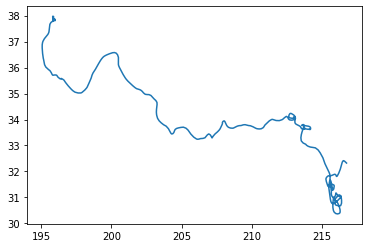

In [2]:
url = "https://raw.githubusercontent.com/oceanhackweek/ohw19-projects-Trackpy/7d62174c4188a0f3d4aaadf848ef91e36da63289/data/example_turtle_track.csv"
track_ex = pd.read_csv(url, parse_dates=['datetime'])

track_ex["lon"] = np.where(
    track_ex["lon"] < 180,
    track_ex["lon"] + 360,
    track_ex["lon"])

lat_min = track_ex["lat"].min() - 2.0
lat_max = track_ex["lat"].max() + 2.0
lon_min = track_ex["lon"].min() - 2.0
lon_max = track_ex["lon"].max() + 2.0

xy_bbox = dict(latitude=slice(lat_min,lat_max), longitude=slice(lon_min,lon_max))

plt.plot(track_ex.lon,track_ex.lat)

{'latitude': slice(24.44818354, 35.90428483, None),
 'longitude': slice(-82.06428163, -71.04951667, None)}

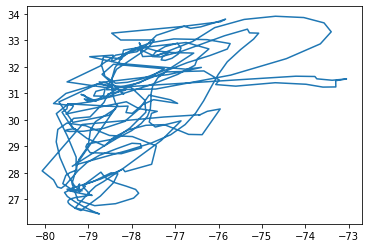

In [3]:
# This is Jackie playing around with Shark Tag data from Laura

shark_dir = "track_shark144020.csv"
track_ex = pd.read_csv(shark_dir, parse_dates=['datetime'])

# track_ex["lon"] = np.where(
#     track_ex["lon"] < 180,
#     track_ex["lon"] + 360,
#     track_ex["lon"])

lat_min = track_ex["lat"].min() - 2.0
lat_max = track_ex["lat"].max() + 2.0
lon_min = track_ex["lon"].min() - 2.0
lon_max = track_ex["lon"].max() + 2.0

xy_bbox = dict(latitude=slice(lat_min,lat_max), longitude=slice(lon_min,lon_max))

plt.plot(track_ex.lon,track_ex.lat)

xy_bbox

Open erddap url for SST product

In [4]:
erddap_opendap_url =  'https://coastwatch.pfeg.noaa.gov/erddap/griddap/jplMURSST41'
ds = xr.open_dataset(erddap_opendap_url)

Next, we will load the SST data over our spatiotemporal domain. First, we must set the temporal domain for the SST product. If you are working with a remotely-sensed product of temporal scale > 1 day, you may need to add days before and after the limits of your animal track in order to make this work.

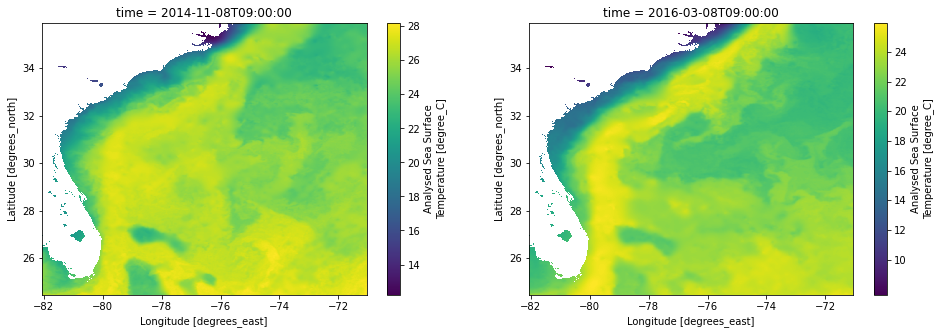

In [5]:
time_min_sst = pd.to_datetime(track_ex['datetime'].min()) - timedelta(minutes=10080)
time_max_sst = pd.to_datetime(track_ex['datetime'].max()) + timedelta(minutes=10080)

subset = ds.sel(time=slice(time_min_sst, time_max_sst), **xy_bbox)

subset_sst = subset.analysed_sst

levels = [10, 12, 14, 16, 18, 20, 22, 24, 26, 28]

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 5))
subset_sst.isel(time=0).plot(ax=ax1, cbar_kwargs={'ticks': levels})
subset_sst.isel(time=-1).plot(ax=ax2, cbar_kwargs={'ticks': levels});

In [6]:

begin_time_2016 = pd.Timestamp('2016-01-01T00')
subset_2016 = subset.sel(time=slice(begin_time_2016, time_max_sst))

In [8]:
row_bbox

<xarray.Dataset>
Dimensions:           (time: 68, latitude: 20, longitude: 10)
Coordinates:
  * time              (time) datetime64[ns] 2016-01-01T09:00:00 ... 2016-03-0...
  * latitude          (latitude) float32 27.09 27.1 27.11 ... 27.26 27.27 27.28
  * longitude         (longitude) float32 -79.03 -79.02 -79.01 ... -78.95 -78.94
Data variables:
    analysed_sst      (time, latitude, longitude) float64 ...
    analysis_error    (time, latitude, longitude) float64 ...
    mask              (time, latitude, longitude) float32 ...
    sea_ice_fraction  (time, latitude, longitude) float64 ...
Attributes: (12/50)
    acknowledgement:            Please acknowledge the use of these data with...
    cdm_data_type:              Grid
    comment:                    MUR = "Multi-scale Ultra-high Resolution"
    Conventions:                CF-1.6, COARDS, ACDD-1.3
    creator_email:              ghrsst@podaac.jpl.nasa.gov
    creator_name:               JPL MUR SST project
    ...                         ...
    summary:                    This is a merged, multi-sensor L4 Foundation ...
    testOutOfDate:              now-3days
    time_coverage_end:          2021-08-03T09:00:00Z
    time_coverage_start:        2002-06-01T09:00:00Z
    title:                      Multi-scale Ultra-high Resolution (MUR) SST A...
    Westernmost_Easting:        -179.99

Now that we have SST loaded in, let's extract SST at each location and time of the animal track. This is similar to the Xtractomatic tool often used in R and Matlab.

In [7]:
sst_df_list = []
for index, row in track_ex.iterrows():
    row_time = pd.to_datetime(row["datetime"]) 
    x = row_time.strftime('%Y-%m-%d')
    row_lat_min = row["lat"] - 0.1
    row_lat_max = row["lat"] + 0.1
    row_lon_min = row["lon"] - 0.05
    row_lon_max = row["lon"] + 0.05
    row_bbox = subset_2016.sel(latitude=slice(row_lat_min,row_lat_max), longitude=slice(row_lon_min,row_lon_max))
    row_sst= row_bbox.sel(time=x)
    sst_xy_mean = row_sst.mean(dim=('latitude', 'longitude'))
    row_todf = sst_xy_mean.to_dataframe()
    #row_todf = row_sst.to_dataframe()
    sst_df_list.append(row_todf)
    #track_ex[]
    
sst_df = pd.concat(sst_df_list, ignore_index = True)
track_ex = pd.concat([track_ex, sst_df], axis=1)

KeyError: '2014-11-15'

Let's plot those SST values

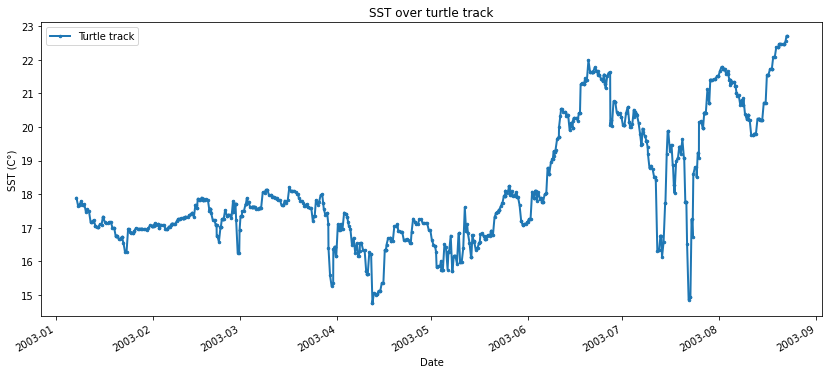

In [7]:
ax = track_ex.plot(x ='datetime', y='sst', figsize=(14,6), lw=2, marker='.', markersize=5, title="SST over turtle track")
ax.set_xlabel("Date")
ax.set_ylabel("SST (C°)")
ax.legend(["Turtle track"])

Now that we've saved in and explored the SST data a bit, let's try folding some mesoscale oceanographic features into this analysis. In this step, you will be asked for your AVISO login credentials in order to interact with their mesoscale eddy track database. 

In [8]:
if not path.exists('eddy_trajectory_2.0exp_19930101_20180118.nc'):
    ftp_add =  'ftp-access.aviso.altimetry.fr'

    username = input('username:')
    password = getpass.getpass()

    ftp = FTP(ftp_add)
    ftp.login(username,password)
    ftp.cwd('value-added/eddy-trajectory/delayed-time/')
    filename = 'eddy_trajectory_2.0exp_19930101_20180118.nc'
    f = open(filename, "wb")
    ftp.retrbinary("RETR " + filename, f.write, 8*1024)
    f.close()
    ftp.close() 

    # keyword argument match 'lon' --> flexible way to look for coords that are labeled different
    # flexible acces to xarray and dataframe

username: lxm958@miami.edu
 ······


TimeoutError: [Errno 110] Connection timed out

Next, we can subset the eddy database to match the geospatial domain of the animal track. Because the eddy database is stored with observation numbers as the only dimension (and with many replicate times and locations from different eddy tracks), slicing with xarray is challenging. Instead, we perform this relatively simple subset operation using the netCDF module and straightforward boolean operators.

In [9]:
eddys = Dataset('eddy_trajectory_2.0exp_19930101_20180118.nc')
t = np.array(eddys['time'])
lat = np.array(eddys['latitude'])
lon = np.array(eddys['longitude'])
cyclonic_type = np.array(eddys['cyclonic_type'])
track = np.array(eddys['track'])
radius = np.array(eddys['speed_radius'])

t = t.astype(np.int32)
dates = pd.to_datetime("1950-01-01 12:00:00")
eddy_time = dates + pd.TimedeltaIndex(t, unit='D')

lon = np.where(
    lon > 180,
    lon - 360,
    lon)

track_ex["lon"] = np.where(
    track_ex["lon"] > 180,
    track_ex["lon"] - 360,
    track_ex["lon"])

lat_min = track_ex.lat.min() - 3
lat_max = track_ex.lat.max() + 3
lon_min = track_ex.lon.min() - 3
lon_max = track_ex.lon.max() + 3
time_min_eddy = track_ex.datetime.min() 
time_max_eddy = track_ex.datetime.max() 


subset = (lat >= lat_min) & (lat <= lat_max) & (lon >= lon_min) & (lon <= lon_max) & (eddy_time >= time_min_eddy) & (eddy_time <= time_max_eddy)
lat = lat[subset]
lon = lon[subset]
eddy_time = eddy_time[subset]
cyclonic_type = cyclonic_type[subset]
track = track[subset]
radius = radius[subset]

eddy_df = pd.DataFrame({"lat":lat,
                        "lon":lon,
                        "datetime":eddy_time,
                        "track":track,
                        "radius":radius,
                        "cyclonic_type":cyclonic_type})
eddy_df.loc[eddy_df['cyclonic_type'] == 1,'color'] = 'blue'
eddy_df.loc[eddy_df['cyclonic_type'] == -1,'color'] = 'red'
eddy_df.head()

FileNotFoundError: [Errno 2] No such file or directory: b'eddy_trajectory_2.0exp_19930101_20180118.nc'

Let's visualize some of these interactions with mesoscale oceanography!

In [10]:
color_scale = np.array(['#ffffb2','#fecc5c','#fd8d3c','#f03b20','#bd0026'])
sst_min = track_ex.sst.min()
sst_max = track_ex.sst.max()
bin_edges = np.arange(sst_min,sst_max,(sst_max-sst_min)/5)
track_ex.loc[track_ex['sst'] <= bin_edges[1] ,'color'] = color_scale[0]
track_ex.loc[(track_ex['sst'] > bin_edges[1]) & (track_ex['sst'] <= bin_edges[2]),'color'] = color_scale[1]
track_ex.loc[(track_ex['sst'] > bin_edges[2]) & (track_ex['sst'] <= bin_edges[3]),'color'] = color_scale[2]
track_ex.loc[(track_ex['sst'] > bin_edges[3]) & (track_ex['sst'] <= bin_edges[4]),'color'] = color_scale[3]
track_ex.loc[track_ex['sst'] > bin_edges[4],'color'] = color_scale[4]

def create_geojson_features(df):
    print('> Creating GeoJSON features...')
    features = []
    for _, row in df.iterrows():
        feature = {
            'type': 'Feature',
            'geometry': {
                'type':'Point', 
                'coordinates':[row['lon'],row['lat']]
            },
            'properties': {
                'time': row['datetime'].date().__str__(),
                'style': {'color' : 'black','weight' : 1, 'opacity' : 0.75},
                'icon': 'circle',
                'iconstyle':{
                    'fillColor': row['color'],
                    'fillOpacity': 1,
                    'stroke': 'true',
                    'radius': 8
                }
            }
        }
        features.append(feature)
    return features

features = create_geojson_features(track_ex)

m = folium.Map(location=[track_ex.lat.mean(), track_ex.lon.mean()], zoom_start=4, tiles=None, control_scale=True)
folium.raster_layers.TileLayer('OpenStreetMap').add_to(m)
folium.raster_layers.TileLayer('stamenterrain').add_to(m)
TimestampedGeoJson(
    {'type': 'FeatureCollection',
    'features': features}
    , period='P1D'
    , add_last_point=True
    , auto_play=False
    , loop=False
    , max_speed=1
    , loop_button=True
    , date_options='YYYY/MM/DD'
    , time_slider_drag_update=True
    , duration='P1D'
).add_to(m)

folium.plugins.Fullscreen(
    position='topright',
    title='Expand me',
    title_cancel='Exit me',
    force_separate_button=True
).add_to(m)
m.add_child(folium.map.LayerControl())

#NEED TO ADD CODE FOR SST COLORMAP LEGEND

m

> Creating GeoJSON features...


In [12]:
def create_geojson_features(df):
    print('> Creating GeoJSON features...')
    features = []
    for _, row in df.iterrows():
        feature = {
            'type': 'Feature',
            'geometry': {
                'type':'Point', 
                'coordinates':[row['lon'],row['lat']]
            },
            'properties': {
                'time': row['datetime'].date().__str__(),
                'style': {'color' : 'black','weight' : 1, 'opacity' : 0.75},
                'icon': 'circle',
                'iconstyle':{
                    'fillColor': 'green',
                    'fillOpacity': 0.5,
                    'stroke': 'true',
                    'radius': 4
                }
            }
        }
        features.append(feature)
    return features

def create_geojson_eddy_features(df):
    print('> Creating GeoJSON Eddy features...')
    features = []
    for _, row in df.iterrows():
        feature = {
            'type': 'Feature',
            'geometry': {
                'type':'Point', 
                'coordinates':[row['lon'],row['lat']]
            },
            'properties': {
                'time': row['datetime'].date().__str__(),
                'style': {'color' : 'black','weight' : 1, 'opacity' : 0.75},
                'icon': 'circle',
                'iconstyle':{
                    'fillColor': row['color'],
                    'fillOpacity': 0.5,
                    'stroke': 'true',
                    'radius': row['radius']/5
                }
            }
        }
        features.append(feature)
    return features

features = create_geojson_features(track_ex)
eddy_features = create_geojson_eddy_features(eddy_df)

m = folium.Map(location=[track_ex.lat.mean(), track_ex.lon.mean()], zoom_start=5, tiles=None, control_scale=True)
folium.raster_layers.TileLayer('OpenStreetMap').add_to(m)
folium.raster_layers.TileLayer('stamenterrain').add_to(m)
TimestampedGeoJson(
    [{'type': 'FeatureCollection',
    'features': eddy_features},
    {'type': 'FeatureCollection',
    'features': features}]
    , period='P1D'
    , add_last_point=True
    , auto_play=False
    , loop=False
    , max_speed=1
    , loop_button=True
    , date_options='YYYY/MM/DD'
    , time_slider_drag_update=True
    , duration='P1D'
).add_to(m)

folium.plugins.Fullscreen(
    position='topright',
    title='Expand me',
    title_cancel='Exit me',
    force_separate_button=True
).add_to(m) 
m.add_child(folium.map.LayerControl())

m

> Creating GeoJSON features...
> Creating GeoJSON Eddy features...
